In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
device = torch.device('cuda:2') if torch.cuda.is_available() else "cpu"
device

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=2)

In [2]:
#reading metadata.csv
import pandas as pd

df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")

df

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split
0,0,4,4,3328,21792,1,0,0,0
1,1,4,4,3200,22272,1,0,0,0
2,2,4,4,3168,22272,1,0,0,0
3,3,4,4,3328,21760,1,0,0,0
4,4,4,4,3232,22240,1,0,0,0
...,...,...,...,...,...,...,...,...,...
455949,455949,88,1,14784,7648,0,45,4,1
455950,455950,99,4,3872,11328,0,49,4,0
455951,455951,92,1,31968,9536,0,47,4,0
455952,455952,81,4,23712,12192,0,41,4,0


In [3]:
import re
from typing import Dict, List, Tuple
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from pathlib import Path
import random
import numpy as np
import pandas as pd
import pathlib
from PIL import Image

num_workers = 2
data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")
batch_size = 32
total_samples, num_samples = 0, 0
seed = 42
num_clients = 5
df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
num_test_clients = 1


def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = ["Non-cancerous", "Cancerous"]
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.center = np.empty(shape=(len(self.paths),))
        # Setup transforms
        df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
        for idx in range(len(self.paths)):
            image_path = self.paths[idx]
            regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
            mo=regex.search(str(image_path)[69:])
            patient,node,x,y = mo.groups()
            patient,node,x,y = int(patient), int(node), int(x), int(y)
            self.center[idx] = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0])


        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        mo=regex.search(str(image_path)[69:])
        # print(mo.groups())
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)

        has_cancer = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = "Cancerous" if has_cancer else "Non-cancerous" # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


def create_dataloaders(data_transform: transforms.Compose):
    random.seed(seed)

    data = ImageFolderCustom(
        targ_dir = data_path,
        transform = data_transform
    )

    total_samples = len(data)
    num_samples = total_samples

    indices = torch.tensor(np.random.permutation(np.arange(total_samples)))

    train_indices=[]
    validate_indices=[]
    test_indices=[]

    num_samples_per_client = int(num_samples/num_clients)
    train_split, val_split = int(0.8*num_samples_per_client), num_samples_per_client - int(0.8*num_samples_per_client)

    for i in range(num_clients):
        if(i < num_clients - num_test_clients):
            train_indices.append(indices[num_samples_per_client*(i): num_samples_per_client*(i) + train_split])
            validate_indices.append(indices[num_samples_per_client*(i) + train_split: num_samples_per_client*(i+1)])
        else:
            test_indices.append(indices[num_samples_per_client*(i): num_samples_per_client*(i + 1)])

    train_datasets = []
    validate_datasets = []
    test_datasets = []

    for i in range(num_clients):
        if(i < num_clients - num_test_clients):
            train_datasets.append(Subset(data, train_indices[i]))
            validate_datasets.append(Subset(data, validate_indices[i]))
        else:
            test_datasets.append(Subset(data, test_indices[i - (num_clients - num_test_clients)]))
    
    train_dataloaders = []
    validate_dataloaders = []
    test_dataloaders = []

    for i in range(num_clients):
        if(i < num_clients - num_test_clients):
            train_dataloaders.append(
                DataLoader(
                    dataset = train_datasets[i],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
            ))

            validate_dataloaders.append(
                DataLoader(
                    dataset = validate_datasets[i],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )
        else:
            test_dataloaders.append(
                DataLoader(
                    dataset = test_datasets[i - (num_clients - num_test_clients)],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )

    return train_dataloaders, validate_dataloaders, test_dataloaders

In [7]:
from tqdm.auto import tqdm
paths = list(pathlib.Path(data_path).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
# print(len(paths))
center = []
# # Setup transforms
df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
for idx in tqdm(range(len(paths))):
    image_path = paths[idx]
    mo=regex.search(str(image_path)[69:])
    patient,node,x,y = mo.groups()
    patient,node,x,y = int(patient), int(node), int(x), int(y)
    center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

100%|██████████| 455954/455954 [10:44<00:00, 707.60it/s] 


In [8]:
center = np.array(center)

In [10]:
np.bincount(center)

array([ 59436,  34904,  85054, 129838, 146722])

In [2]:
0.2*(59436+34904+85054+129838+146722)

91190.8

In [5]:
data = ImageFolderCustom(
    targ_dir=data_path,
    transform=None
)


KeyboardInterrupt: 

In [44]:
# Make function to find classes in target directory
from typing import Dict, List, Tuple
import pathlib
import re
import numpy as np
import random
from PIL import Image

def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = ["Non-cancerous", "Cancerous"]
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)[32:64, 32:64, :]
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        mo=regex.search(str(image_path)[69:])
    # print(mo.groups())
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)

        has_cancer = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = "Cancerous" if has_cancer else "Non-cancerous" # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [45]:
from torch.utils.tensorboard import SummaryWriter
import torchinfo
writer = SummaryWriter()

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

## Dataset Prep

In [54]:
from pathlib import Path

data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy

BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_SAMPLES=20000
total_samples=100000

data_transform = transforms.Compose([
    transforms.ToTensor()
])

data = ImageFolderCustom(
    targ_dir = data_path,
    transform=data_transform
)

indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples)))

train_indices = []
validate_indices=[]
test_indices = []

for i in range(5):
    train_indices.append(indices[NUM_SAMPLES*(i):NUM_SAMPLES*(i) + 16000])
    validate_indices.append(indices[NUM_SAMPLES*(i) + 16000: NUM_SAMPLES*(i) + 18000])
    test_indices.append(indices[NUM_SAMPLES*(i) + 18000: NUM_SAMPLES*(i) + NUM_SAMPLES])

print("Indices made")

train_datasets = []
validate_datasets = []
test_datasets = []

for i in range(5):
    train_datasets.append(Subset(data, train_indices[i]))
    validate_datasets.append(Subset(data, validate_indices[i]))
    test_datasets.append(Subset(data, test_indices[i]))

print("Datasets made")


print(len(train_datasets[0]), len(test_datasets[0]), len(validate_datasets[0]))

train_dataloaders = []
validate_dataloaders = []
test_dataloaders = []

for i in range(5):
    train_dataloaders.append(DataLoader(
        dataset=train_datasets[i],
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers= NUM_WORKERS,
        pin_memory = True
    ))

    validate_dataloaders.append(DataLoader(
        dataset=validate_datasets[i],
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers= NUM_WORKERS,
        pin_memory = True
    ))

    test_dataloaders.append(DataLoader(
        dataset=test_datasets[i],
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers= NUM_WORKERS,
        pin_memory = True
    ))

print("DataLoaders made")


Indices made
Datasets made
16000 2000 2000
DataLoaders made


In [55]:
print(data.classes)

['Non-cancerous', 'Cancerous']


In [47]:
from typing import Type

class Client:
    def __init__(self, 
                model_type: Type[nn.Module], 
                loss_fn: Type[nn.Module],
                optimizer: Type[torch.optim.Optimizer],
                train_dataloader: Type[DataLoader],
                validate_dataloader: Type[DataLoader],
                test_dataloader: Type[DataLoader],
                lr
            ):
        self.model = model_type().to(device)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(self.model.parameters(), lr)
        self.test_dataloader = test_dataloader
        self.validate_dataloader = validate_dataloader
        self.train_dataloader = train_dataloader
        self.lr = lr
    
    def refresh(self):
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.__class__()
        self.optimizer = self.optimizer.__class__(self.model.parameters(), self.lr)
    
    def train_step(self):
        self.model.train()

        train_loss, train_acc = 0.0, 0.0

        for batch, (x,y) in enumerate(self.train_dataloader):
            x,y = x.to(device), y.to(device)
            y_pred = self.model(x)

            loss = self.loss_fn(y_pred, y)
            train_loss += loss.item()

            self.optimizer.zero_grad()

            loss.backward()

            self.optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        train_loss /= len(self.train_dataloader)
        train_acc /= len(self.train_dataloader)
        
        return train_loss, train_acc

    
    def validate_step(self):

        self.model.eval()

        test_loss, test_acc = 0.0,0.0
        
        with torch.inference_mode():

            for batch, (x,y) in enumerate(self.validate_dataloader):
                x, y = x.to(device), y.to(device)

                y_pred_logits = self.model(x)

                loss = self.loss_fn(y_pred_logits, y)
                test_loss += loss.item()

                y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
                test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)

        
        test_loss /= len(self.validate_dataloader)
        test_acc /= len(self.validate_dataloader)

    
        return test_loss, test_acc


    def train(self, epochs, writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:

        results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
        }

        for epoch in range(epochs):
            train_loss, train_acc = self.train_step()

            test_loss, test_acc = self.validate_step()

            # print(
            #     f"Epoch: {epoch+1} | "
            #     f"train_loss: {train_loss:.4f} | "
            #     f"train_acc: {train_acc:.4f} | "
            #     f"test_loss: {test_loss:.4f} | "
            #     f"test_acc: {test_acc:.4f}"
            # )
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            if writer:
                # Add results to SummaryWriter
                writer.add_scalars(main_tag="Loss", 
                                tag_scalar_dict={"train_loss": train_loss,
                                                    "test_loss": test_loss},
                                global_step=epoch)
                writer.add_scalars(main_tag="Accuracy", 
                                tag_scalar_dict={"train_acc": train_acc,
                                                    "test_acc": test_acc}, 
                                global_step=epoch)

                # Close the writer
                writer.close()
            else:
                pass
        ### End new ###

        return results


In [48]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
class Server:
    def __init__(self,
        num_clients,
        model_type: Type[nn.Module], 
        loss_fn: Type[nn.Module],
        optimizer: Type[torch.optim.Optimizer],
        lr
        ):

        self.NUM_CLIENTS = num_clients
        self.model_type = model_type
        self.model = model_type().to(device)
        self.loss_fn_type = loss_fn
        self.optimizer_type = optimizer
        train_dataloaders, validate_dataloaders, test_dataloaders = self.make_data(batch_size=32, num_workers=2)
        self.clients = []
        for i in range(self.NUM_CLIENTS):
            new_client = Client(model_type=self.model_type, 
                                loss_fn = self.loss_fn_type,
                                optimizer=self.optimizer_type,
                                train_dataloader = train_dataloaders[i],
                                validate_dataloader=validate_dataloaders[i],
                                test_dataloader=test_dataloaders[i],
                                lr=lr)
            self.clients.append(new_client)
        


    def make_data(self,
        batch_size,
        num_workers
        ):

        data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")
        BATCH_SIZE = batch_size
        NUM_WORKERS = num_workers
        NUM_CLIENTS = self.NUM_CLIENTS

        data_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        data = ImageFolderCustom(
            targ_dir = data_path,
            transform=data_transform
        )

        total_samples=len(data)
        NUM_SAMPLES=total_samples/NUM_CLIENTS
        
        indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples)))

        train_indices = []
        validate_indices=[]
        test_indices = []

        NUM_SAMPLES = int(NUM_SAMPLES)
        train_split, val_split, test_split = int(0.8*NUM_SAMPLES), int(0.1*NUM_SAMPLES), int(0.1*NUM_SAMPLES)

        for i in range(NUM_CLIENTS):
            train_indices.append(indices[NUM_SAMPLES*(i):NUM_SAMPLES*(i) + train_split])
            validate_indices.append(indices[NUM_SAMPLES*(i) + train_split: NUM_SAMPLES*(i) + train_split+val_split])
            test_indices.append(indices[NUM_SAMPLES*(i) + train_split+val_split: NUM_SAMPLES*(i) + NUM_SAMPLES])

        # print("Indices made")

        train_datasets = []
        validate_datasets = []
        test_datasets = []

        for i in range(NUM_CLIENTS):
            train_datasets.append(Subset(data, train_indices[i]))
            validate_datasets.append(Subset(data, validate_indices[i]))
            test_datasets.append(Subset(data, test_indices[i]))

        # print("Datasets made")


        # print(len(train_datasets[0]), len(test_datasets[0]), len(validate_datasets[0]))

        train_dataloaders = []
        validate_dataloaders = []
        test_dataloaders = []

        for i in range(NUM_CLIENTS):
            train_dataloaders.append(DataLoader(
                dataset=train_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))

            validate_dataloaders.append(DataLoader(
                dataset=validate_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))

            test_dataloaders.append(DataLoader(
                dataset=test_datasets[i],
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers= NUM_WORKERS,
                pin_memory = True
            ))
            
        return train_dataloaders, validate_dataloaders, test_dataloaders
        # print("DataLoaders made")
    
    def run(self,
        server_epochs,
        client_epochs,
        folder_path):

        for epoch in tqdm(range(server_epochs)):
            train_loss, validate_loss = 0,0
            train_acc, validate_acc = 0,0
            for j in range(self.NUM_CLIENTS):
                results = self.clients[i].train(epochs = client_epochs, writer = None)
                train_loss += results["train_loss"][-1]
                validate_loss += results["test_loss"][-1]
                train_acc += results["train_acc"][-1]
                validate_acc += results["test_acc"][-1]

                p = folder_path/f"models/client-{j}/"
                p.mkdir(parents=True, exist_ok=True)
                file_path = p/f"epoch-{epoch}.pt"

                torch.save(obj=self.clients[j].model.state_dict(), f=file_path)
            train_loss /= self.NUM_CLIENTS
            validate_loss /= self.NUM_CLIENTS
            train_acc /= self.NUM_CLIENTS
            validate_acc /= self.NUM_CLIENTS

            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"validate_loss: {validate_loss:.4f} | "
                f"validate_acc: {validate_acc:.4f}"
            )

            self.model.load_state_dict(self.clients[0].model.state_dict())
            for j in range(1, self.NUM_CLIENTS):
                for(key, value) in self.model.state_dict().items():
                    self.model.state_dict()[key].copy_(self.clients[j].model.state_dict()[key] + value)
            
            for (key, value) in self.model.state_dict().items():
                self.model.state_dict()[key].copy_(value/self.NUM_CLIENTS)

            for j in range(self.NUM_CLIENTS):
                self.clients[j].model.load_state_dict(self.model.state_dict())
                self.clients[j].refresh()
                
            
            final_loss, final_acc = 0,0
            for client in self.clients:
                temp_loss, temp_acc = client.validate_step()
                final_loss += temp_loss
                final_acc += temp_acc
            
            final_loss /= self.NUM_CLIENTS
            final_acc /= self.NUM_CLIENTS

            print(
                "Aggregated Model"
                f"Epoch: {epoch+1} | "
                f"validate_loss: {final_loss:.4f} | "
                f"validate_acc: {final_acc:.4f}"
            )        

            p = folder_path/"models/server/"
            p.mkdir(parents = True, exist_ok = True)
            p_file = p/f"epoch-{epoch}.pt"
            torch.save(obj=self.model.state_dict(), f=p_file)

Random image path: /local/scratch/camelyon17/camelyon17_v1.0/patches/patient_096_node_0/patch_patient_096_node_0_x_36128_y_5664.png
Image class: patient_096_node_0
Image height: 96
Image width: 96


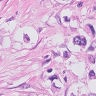

In [49]:
# Printing random image
import random
from PIL import Image

random.seed(42)

image_path_list = list(data_path.glob("*/*.png"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [56]:
NUM_CLASSES = len(data.classes)
TOTAL_PIXELS = torch.numel(data[0][0])

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.layer1 = nn.Linear(
            in_features = TOTAL_PIXELS,
            out_features=200    
        )
        self.layer2 = nn.Linear(
            in_features=200,
            out_features=200
        )
        self.classifier = nn.Linear(
            in_features = 200,
            out_features = NUM_CLASSES
        )

    def forward(self, x):
        return self.classifier(torch.relu(self.layer2(torch.relu(self.layer1(self.flatten(x))))))

In [57]:
model0 = MultiLayerPerceptron()

img = data[0][0]
model0(img.unsqueeze(dim=0))

tensor([[-0.0097,  0.0291]], grad_fn=<AddmmBackward0>)

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

server = Server(
    num_clients=5,
    model_type= MultiLayerPerceptron,
    loss_fn=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    lr=0.001
)

server.run(
    server_epochs=5,
    client_epochs=1,
    folder_path = Path("MultiLayerPerceptron/client-1-server-5")
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6805 | train_acc: 0.6382 | validate_loss: 0.6788 | validate_acc: 0.6264


 20%|██        | 1/5 [08:56<35:47, 536.87s/it]

Aggregated ModelEpoch: 1 | validate_loss: 0.6934 | validate_acc: 0.4968
Epoch: 2 | train_loss: 0.6913 | train_acc: 0.5956 | validate_loss: 0.6909 | validate_acc: 0.6093


 40%|████      | 2/5 [18:18<27:33, 551.25s/it]

Aggregated ModelEpoch: 2 | validate_loss: 0.6929 | validate_acc: 0.4968
Epoch: 3 | train_loss: 0.6906 | train_acc: 0.6049 | validate_loss: 0.6901 | validate_acc: 0.6092


 60%|██████    | 3/5 [27:53<18:44, 562.10s/it]

Aggregated ModelEpoch: 3 | validate_loss: 0.6923 | validate_acc: 0.4968
Epoch: 4 | train_loss: 0.6897 | train_acc: 0.6119 | validate_loss: 0.6891 | validate_acc: 0.6207


 80%|████████  | 4/5 [37:18<09:23, 563.25s/it]

Aggregated ModelEpoch: 4 | validate_loss: 0.6917 | validate_acc: 0.4968
Epoch: 5 | train_loss: 0.6887 | train_acc: 0.6190 | validate_loss: 0.6880 | validate_acc: 0.6294


100%|██████████| 5/5 [46:15<00:00, 555.08s/it]

Aggregated ModelEpoch: 5 | validate_loss: 0.6908 | validate_acc: 0.4871


In [68]:
NUM_CLASSES = len(data.classes)
class ConvolutionalNN(nn.Module):
    def __init__(self, input_channels: int = 3, output_shape: int = NUM_CLASSES):
        super().__init__()
        self.conv_block_1 = nn.Conv2d(
            in_channels= input_channels,
            out_channels= 32,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.conv_block_2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.linear_layer = nn.Linear(
            in_features= 64*8*8,
            out_features = 512,
        )

        self.classifier = nn.Linear(
            in_features = 512,
            out_features = NUM_CLASSES
        )

        self.max_pool2d = nn.MaxPool2d(2)

    def forward(self, x):
        return self.classifier(self.linear_layer(nn.Flatten()(self.max_pool2d(self.conv_block_2(self.max_pool2d(self.conv_block_1(x)))))))


        

In [69]:
model1 = ConvolutionalNN(input_channels=3, output_shape = len(data.classes))
model1(data[0][0].unsqueeze(dim=0))
# len(data.classes)

tensor([[ 0.0949, -0.0301]], grad_fn=<AddmmBackward0>)

In [70]:
server = Server(
    num_clients=5,
    model_type= ConvolutionalNN,
    loss_fn=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001
)

server.run(
    server_epochs=5,
    client_epochs=5,
    folder_path = Path("ConvoultionalNN/client-5-server-5")
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2602 | train_acc: 0.8948 | validate_loss: 0.4849 | validate_acc: 0.8348


 20%|██        | 1/5 [41:09<2:44:36, 2469.10s/it]

Aggregated ModelEpoch: 1 | validate_loss: 0.6921 | validate_acc: 0.5018
Epoch: 2 | train_loss: 0.2089 | train_acc: 0.9177 | validate_loss: 0.5489 | validate_acc: 0.8345


 40%|████      | 2/5 [1:20:55<2:01:01, 2420.62s/it]

Aggregated ModelEpoch: 2 | validate_loss: 0.6621 | validate_acc: 0.5447
Epoch: 3 | train_loss: 0.1754 | train_acc: 0.9328 | validate_loss: 0.7116 | validate_acc: 0.8248


 60%|██████    | 3/5 [2:06:59<1:25:54, 2577.15s/it]

Aggregated ModelEpoch: 3 | validate_loss: 0.6038 | validate_acc: 0.6044
Epoch: 4 | train_loss: 0.1585 | train_acc: 0.9408 | validate_loss: 0.7268 | validate_acc: 0.8238


 80%|████████  | 4/5 [2:55:04<44:58, 2698.78s/it]  

Aggregated ModelEpoch: 4 | validate_loss: 0.5687 | validate_acc: 0.6667
